# Fully combined approach

search for optimal hyperparameters and compare optimal coefficients with previous ones

In [1]:
import pandas
import os
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

from MDRefine import load_data, minimizer, hyper_minimizer, MDRefinement

### Load data

In [3]:
infos = {'global': {
    'path_directory': '../../DATA',
    'system_names': ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs', 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 100

In [4]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [5]:
infos['global']['forward_model'] = forward_model_fun

choose among force-field correction on $\alpha,\zeta$ or only on $\alpha$ dihedral angles 

In [6]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [7]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


In [8]:
def forward_model_regularization(coeffs, coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [9]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

#### scan over $\beta$

In [ ]:
from MDRefine import select_traintest

In [ ]:
betas = [0, 1e-2, 1e-1, 1, 2, 5, 10, 20, 50, 100, 1e3, 1e4, 1e5, 1e6]

Results = {}

out = select_traintest(data, random_state=1)
data_train = out[0]
data_test = out[1]

for beta in betas:
    Results[beta] = minimizer(data_train, regularization=regularization, beta=beta, data_test=data_test)


Input random_state employed both for test_obs and test_frames
New evaluation:
loss:  19228.767429363183
gradient:  [-40982.00940073   -811.71748055] 

New evaluation:
loss:  7633.475470122439
gradient:  [2360.47618867 2876.96265324] 

New evaluation:
loss:  348713.32755229017
gradient:  [ -7414.65872193 -74528.05572227] 

New evaluation:
loss:  6899.472465817587
gradient:  [2457.16565017 3557.41107508] 

New evaluation:
loss:  5909.878208149686
gradient:  [2175.56398525 4126.91010821] 

New evaluation:
loss:  95712.35225673097
gradient:  [-42302.25237286 -45807.85422238] 

New evaluation:
loss:  4829.733506448952
gradient:  [1512.56388642 4216.34012206] 

New evaluation:
loss:  4006.9767125225108
gradient:  [ 945.47186664 3214.26048518] 

New evaluation:
loss:  32105.509415856104
gradient:  [ -9963.90508649 -30603.57506708] 

New evaluation:
loss:  3695.7624758668753
gradient:  [ 790.36282065 1725.77745415] 

New evaluation:
loss:  37747.94924887825
gradient:  [-15432.07210623 -31187.4

In [ ]:
vars(Results[0]).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new', 'loss_test', 'reg_ff_test', 'av_g_test', 'chi2_test', 'weights_new_test', 'logZ_new_test', 'avg_new_obs', 'chi2_new_obs'])

In [ ]:
tot_chi2 = {}
tot_chi2_new_frames = {}
tot_chi2_new_obs = {}

for beta in betas:
    tot_chi2[beta] = np.sum([s2 for s in Results[beta].chi2.values() for s2 in s.values()])
    tot_chi2_new_frames[beta] = np.sum([s2 for s in Results[beta].chi2_test.values() for s2 in s.values()])
    tot_chi2_new_obs[beta] = np.sum([s2 for s in Results[beta].chi2_new_obs.values() for s2 in s.values()])

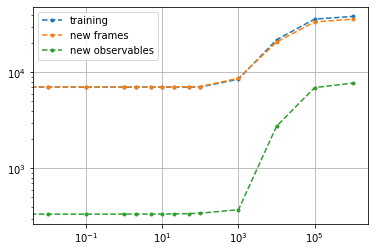

In [ ]:
plt.plot(betas, tot_chi2.values(), '.--', label='training')
plt.plot(betas, tot_chi2_new_frames.values(), '.--', label='new frames')
plt.plot(betas, tot_chi2_new_obs.values(), '.--', label='new observables')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()


### Case 1: ensemble + forward-model refinement
which_set = 'test'

random_states = 2

#### a. search for optimal hyperparameters

In [10]:
starting_alpha = 10**2
starting_beta = np.inf
starting_gamma = 1  # np.inf

which_set = 'test'
random_states = 2

which_set = 'validation' (new frames) or 'test' (new observables); 'validation' by default

In [15]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=starting_alpha,
    starting_beta=starting_beta, starting_gamma=starting_gamma, random_states=random_states,
    which_set=which_set, ftol=1e-3)#, gtol=1e-3)
    #    ftol=1e-5, gtol=1e-1, which_set=which_set)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 2.0), ('gamma', 0.0)]
av. chi2:  1091.539163038846
av. gradient:  [-144.978591     -0.97432519]

log10 hyperpars:  [('alpha', 2.9999774183640104), ('gamma', 0.006720324549352648)]


KeyboardInterrupt: 

In [ ]:
MDRefinement(infos, regularization=regularization, starting_alpha=1, starting_beta=1,
    starting_gamma=1, random_states=2, which_set=which_set, result_folder_name='my_results')


In [12]:
hyper_out

          fun: DeviceArray(1082.68015777, dtype=float64)
     hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.Functions.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f8325d05e48>
          jac: array([-74.7911058 ,  -0.60060544])
      message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
         nfev: 8
          nit: 7
         njev: 8
       status: 0
      success: True
            x: array([ 2.07536687, -0.01485306])

In [14]:
opt_alpha, opt_beta, opt_gamma = 10**hyper_out.x
# opt_alpha = np.Inf

print(opt_alpha, opt_beta, opt_gamma)

82956.87336976845 0.44066000608439776 3.5129785392948234


In [12]:
opt_alpha, opt_gamma = 10**hyper_out.x
opt_beta = np.inf

print(opt_alpha, opt_beta, opt_gamma)

49.54716895520075 inf 0.5602270422746097


In [104]:
opt_alpha, opt_beta = 10**np.array([1.6602592646792638, 0.18965754178601119])
opt_gamma = np.inf

print(opt_alpha, opt_beta, opt_gamma)

45.73611431242951 1.5475957977240775 inf


In [15]:
opt_beta = 10**hyper_out.x[0]

opt_alpha = np.inf
opt_gamma = np.inf

print(opt_beta)

0.03221894323178243


#### b. search for optimal coefficients at determined hyperparameters

In [133]:
opt_alpha = 174.33288
opt_gamma = 3.43332*2

In [105]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, beta=opt_beta, gamma=opt_gamma)

New evaluation:
loss:  232.7775063864291
gradient:  [-37.0212414    4.08287548] 

New evaluation:
loss:  245.3460714147288
gradient:  [29.0617649   3.33683677] 

New evaluation:
loss:  227.88673682104175
gradient:  [0.39361561 4.8087318 ] 

New evaluation:
loss:  227.0003255510407
gradient:  [14.92162039 -5.84433767] 

New evaluation:
loss:  225.32522774335138
gradient:  [5.35356064 2.72281764] 

New evaluation:
loss:  226.8390533430014
gradient:  [ 5.77921253 -5.89466781] 

New evaluation:
loss:  224.31325816571737
gradient:  [7.07773526 0.3337324 ] 

New evaluation:
loss:  224.1468880065155
gradient:  [ 0.51576118 -1.19788293] 

New evaluation:
loss:  224.09235389804087
gradient:  [-0.78172507  0.34893636] 

New evaluation:
loss:  224.08546209119567
gradient:  [0.05117922 0.00877776] 

New evaluation:
loss:  224.08545820981405
gradient:  [0.04739031 0.00068256] 

New evaluation:
loss:  224.08546098424165
gradient:  [0.04854637 0.00189173] 

New evaluation:
loss:  224.08546764980898
g

In [14]:
vars(Result)

{'loss': DeviceArray(213.96887178, dtype=float64),
 'pars': array([10.16505107, -1.86078883, -0.1741575 , 19.24931188, -5.08950932,
        -0.33738188,  8.05111725, -1.76949318,  0.06056918]),
 'mini':       fun: 213.96887178273414
  hess_inv: array([[ 4.62592691e+00,  7.21946523e-01, -1.69167859e+00,
         -2.10601788e-01,  1.42175977e-02,  1.00679989e-01,
         -7.89530110e-01,  3.55870139e-01,  1.72517147e-01],
        [ 7.21946523e-01,  1.02368573e+00, -6.62989265e-01,
         -5.49474431e-02,  8.04738443e-03,  2.23069669e-02,
         -1.51671907e-01,  7.19948877e-02,  3.26037014e-02],
        [-1.69167859e+00, -6.62989265e-01,  8.56728279e-01,
          5.30350156e-02, -2.03440657e-03, -2.13563183e-02,
          2.83536969e-01, -1.19316743e-01, -7.87470554e-02],
        [-2.10601788e-01, -5.49474431e-02,  5.30350156e-02,
          1.58100230e+00, -5.56170916e-01, -3.47076202e-01,
          1.60343139e-01, -7.93383061e-02, -7.15729011e-03],
        [ 1.42175977e-02,  8.047

In [135]:
Result.D_KL_alpha

{'AAAA': DeviceArray(0.12610046, dtype=float64),
 'CAAU': DeviceArray(1.00394874, dtype=float64),
 'CCCC': DeviceArray(0.57323848, dtype=float64),
 'GACC': DeviceArray(0.01993576, dtype=float64),
 'UUUU': DeviceArray(0.22234128, dtype=float64),
 'UCAAUC': DeviceArray(1.22260811, dtype=float64)}

In [19]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

In [101]:
tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print(1/2*tot_chi2)

print(opt_gamma*Result.reg_fm)
print(opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]))

opt_gamma*Result.reg_fm + opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]) + 1/2*tot_chi2

174.27007569044167
1.9138452596645963
37.78557976629863


213.9695007164049

In [136]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(Result.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = ['A_gamma', 'B_gamma', 'C_gamma', 'A_beta', 'B_beta', 'C_beta', 'A_sugar', 'B_sugar', 'C_sugar']
    my_fm_coeffs = pandas.Series(Result.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)

A_gamma     9.771792
B_gamma    -1.822345
C_gamma    -0.055423
A_beta     16.824910
B_beta     -5.695030
C_beta      0.886382
A_sugar     8.740406
B_sugar    -1.819099
C_sugar    -0.071394
dtype: float64


In [103]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(Result.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = ['A_gamma', 'B_gamma', 'C_gamma', 'A_beta', 'B_beta', 'C_beta', 'A_sugar', 'B_sugar', 'C_sugar']
    my_fm_coeffs = pandas.Series(Result.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)

A_gamma     9.898174
B_gamma    -1.813867
C_gamma    -0.132931
A_beta     19.086546
B_beta     -5.081664
C_beta     -0.238991
A_sugar     7.654631
B_sugar    -1.707752
C_sugar     0.258250
dtype: float64


#### c. plot coefficients and compare them with previously determined values

sin,cos: 0.5670107992298928,-0.7708171840600693,

gamma: 10.073939647568015,-1.7274624854944427,-0.18103683805065413,

beta: 18.139363745072547,-5.287610829632396,0.06806038237686833,

sugar: 7.0217099769604605,-1.6419076545887323,0.648997186035425

alpha = 10**2.9822059969013717

beta = 10**2.225141867809032

gamma = 10**-0.3749357545683457

sin,cos: 0.584369, -0.79189575,

gamma: 9.93293172, -1.75313237, -0.12452308,

beta: 18.11038972, -5.30036147,  0.08335626,

sugar: 6.98232334, -1.63483294, 0.66851206

In [10]:
alpha = 10**2.9822059969013717
beta = 10**2.225141867809032
gamma = 10**-0.3749357545683457

print(alpha, beta, gamma)

959.8558075410098 167.9352510360774 0.421758889848375


##### force-field correction

In [11]:
ff_coeffs = {'now': {'sin alpha': 0.584369, 'cos alpha': -0.79189575},#my_ff_coeffs.to_dict(),
    'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
    'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

In [12]:
ff_coeffs

{'now': {'sin alpha': 0.584369, 'cos alpha': -0.79189575},
 'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
 'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

Text(0, 0.5, '$\\Delta V \\, (k_B T)$')

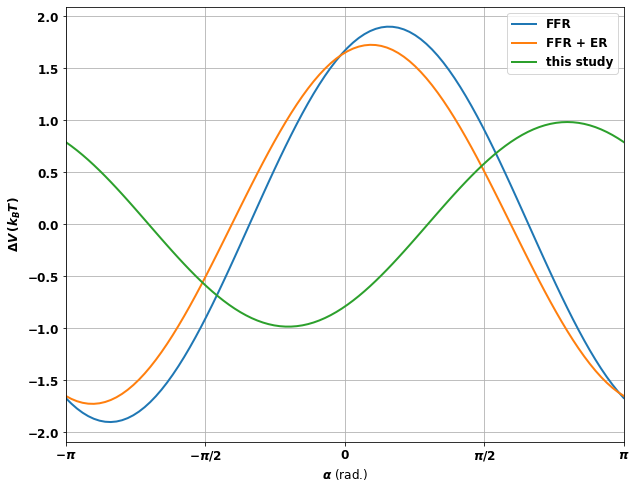

In [42]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

angles = np.linspace(-np.pi, np.pi, 100)

plt.figure(figsize=(10, 8))

deltaV = {}

labels = ['FFR', 'FFR + ER', 'this study']

for i, s in enumerate(['FFR', 'ER+FFR', 'now']):
    deltaV[s] = ff_coeffs[s]['cos alpha']*np.cos(angles) + ff_coeffs[s]['sin alpha']*np.sin(angles)

    plt.plot(angles, deltaV[s], '-', label=labels[i])

plt.legend()
plt.grid()
# plt.title(r'force-field correction $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.ylabel('$\Delta V \, (k_B T)$')

In [13]:
sys_names = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

my_angles = {}

for s in sys_names:

    my_angles[s] = []
    length = len(data[s].f.T)//2

    for i in range(length):

        angles = np.arcsin(data[s].f[:, i])
        wh = np.argwhere(data[s].f[:, i + length] < 0)
        angles[wh] = np.pi - angles[wh]
        angles = np.mod(angles, 2*np.pi)

        wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
        angles[wh] = angles[wh] - 2*np.pi

        my_angles[s].append(angles)

In [14]:
sys_names = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

In [18]:
weights_ff = {}
weights_ff['fully'] = {}
weights_ff['fully with ER'] = {}

for s in sys_names:
    weights_ff['fully'][s] = np.load('../../Results/Result_2024_09_02_15_16_24_894982/weights_ff_%s.npy' % s)
    weights_ff['fully with ER'][s] = np.load('../../Results/Result_2024_09_02_15_16_24_894982/weights_new_%s.npy' % s)

In [22]:
coeffs = ff_coeffs['FFR']

weights_ff['FFR'] = {}

for s in sys_names:
    dV = np.zeros(len(my_angles[s][0]))
    for i in range(len(my_angles[s])):
        dV += coeffs['sin alpha']*np.sin(my_angles[s][i]) + coeffs['cos alpha']*np.cos(my_angles[s][i])
    weights = np.exp(-dV)

    weights_ff['FFR'][s] = weights/np.sum(weights)

coeffs = ff_coeffs['ER+FFR']

weights_ff['FFR+ER'] = {}

for s in sys_names:
    dV = np.zeros(len(my_angles[s][0]))
    for i in range(len(my_angles[s])):
        dV += coeffs['sin alpha']*np.sin(my_angles[s][i]) + coeffs['cos alpha']*np.cos(my_angles[s][i])
    weights = np.exp(-dV)

    weights_ff['FFR+ER'][s] = weights/np.sum(weights)

In [31]:
my_hists = {}

my_list = ['original', 'fully', 'fully with ER', 'FFR', 'FFR+ER']

for s in my_list:
    my_hists[s] = {}

bins = np.arange(-np.pi, np.pi, 0.1)

for s in sys_names:
    for s2 in my_list:
        my_hists[s2][s] = []
    
    for i in range(len(my_angles[s])):
        my_hists['original'][s].append(np.histogram(my_angles[s][i], bins=bins, density=True))
        for s2 in my_list[1:]:
            my_hists[s2][s].append(np.histogram(my_angles[s][i], bins=bins, density=True, weights=weights_ff[s2][s]))


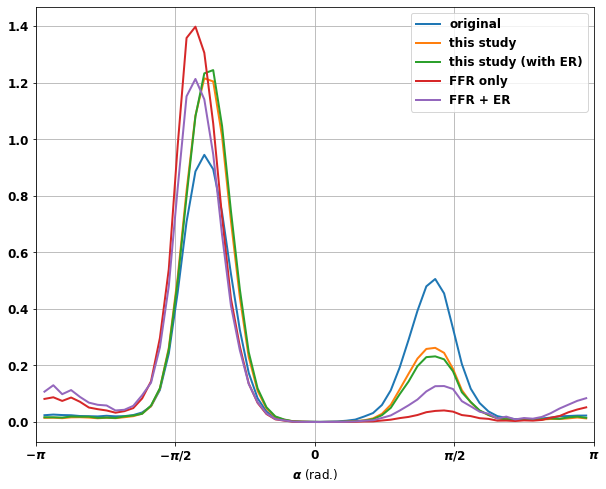

In [40]:
plt.figure(figsize=(10, 8))

tot_hist = {}

for s2 in my_list:
    tot_hist[s2] = np.zeros(len(my_hists['original']['AAAA'][0][0]))

counter = 0

for s in sys_names:
    for i in range(len(my_hists['original'][s])):
        for s2 in my_list:
            tot_hist[s2] += my_hists[s2][s][i][0]
        counter += 1

labels = ['original', 'this study', 'this study (with ER)', 'FFR only', 'FFR + ER']

for i, s2 in enumerate(my_list):
    tot_hist[s2] = tot_hist[s2]/counter

    plt.plot(my_hists['original'][s][i][1][1:], tot_hist[s2], label=labels[i])

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.legend()
plt.grid()

In [75]:
df = pandas.read_csv('../../Results/Result_2024_09_02_15_16_24_894982/result')

cols = [s for s in df.columns if s.startswith('D_KL_alpha')]
print(df[cols])

cols = [s for s in df.columns if s.startswith('reg_ff')]
print(df[cols])


   D_KL_alpha_AAAA  D_KL_alpha_CAAU  D_KL_alpha_CCCC  D_KL_alpha_GACC  \
0         0.021826         0.181036         0.052397         0.000184   

   D_KL_alpha_UUUU  D_KL_alpha_UCAAUC  
0         0.039141           0.422884  
   reg_ff_AAAA  reg_ff_CAAU  reg_ff_CCCC  reg_ff_GACC  reg_ff_UUUU  \
0     0.347099     0.570642     0.523784     0.260738     0.392653   

   reg_ff_UCAAUC  
0       0.466802  


In [ ]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

angles = np.linspace(-np.pi, np.pi, 100)

plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

deltaV = {}

labels = ['FFR', 'ER+FFR', 'ER+FFR+FMR']

for i,s in enumerate(['FFR', 'ER+FFR', 'now']):
    deltaV[s] = ff_coeffs[s]['cos alpha']*np.cos(angles) + ff_coeffs[s]['sin alpha']*np.sin(angles)

    ax1.plot(angles, deltaV[s], '-', label=labels[i])

ax1.legend()
ax1.grid()
# plt.title(r'force-field correction $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')

ax2.plot(hist['AAAA'][0][1][1:], tot_hist)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
ax2.grid()

Text(0.5, 0, '$\\alpha$ (rad.)')

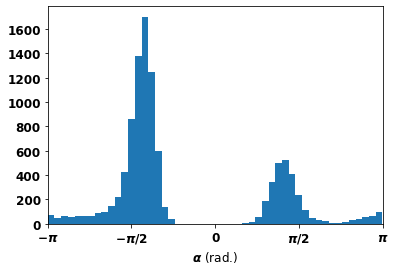

In [19]:
plt.hist(my_angles['AAAA'][0], bins=50)  # , weights=data['AAAA'].weights)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')

In [29]:
ff_coeffs

{'now': {'sin alpha': 0.584369, 'cos alpha': -0.79189575},
 'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
 'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

(-3.141592653589793, 3.141592653589793)

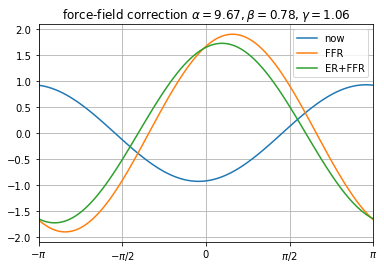

In [32]:
angles = np.linspace(-np.pi, np.pi, 100)

plt.figure()
deltaV = {}

for s in ['now', 'FFR', 'ER+FFR']:
    deltaV[s] = ff_coeffs[s]['cos alpha']*np.cos(angles) + ff_coeffs[s]['sin alpha']*np.sin(angles)

    plt.plot(angles, deltaV[s], '-', label=s)

plt.legend()
plt.grid()
plt.title(r'force-field correction $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])

In [20]:
s = 'AAAA'

i = 2

angles = np.arcsin(data[s].f[:, i])
wh = np.argwhere(data[s].f[:, i + 6] < 0)
angles[wh] = np.pi - angles[wh]
angles = np.mod(angles, 2*np.pi)

wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
angles[wh] = angles[wh] - 2*np.pi

angles

array([-1.43053038, -1.2610528 , -1.68009641, ...,  1.72666202,
       -1.41438142, -1.26707563])

In [17]:
df = pandas.read_csv('Result_2024_09_02_15_16_24_894982/result')

cols = [s for s in df.columns if s.startswith('D_KL_alpha')]
df[cols]

,D_KL_alpha_AAAA,D_KL_alpha_CAAU,D_KL_alpha_CCCC,D_KL_alpha_GACC,D_KL_alpha_UUUU,D_KL_alpha_UCAAUC
0,0.021826,0.181036,0.052397,0.000184,0.039141,0.422884


In [20]:
folder_name = 'Result_2024_09_02_15_16_24_894982'

class Result: pass

Result.weights_new = {}
Result.weights_P = {}

for s in ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']:
    Result.weights_new[s] = np.load(folder_name + '/weights_new_%s.npy' % s)
    Result.weights_P[s] = np.load(folder_name + '/weights_ff_%s.npy' % s)

In [21]:
s = 'UCAAUC'

1078.5995576360742
9.382536761075283


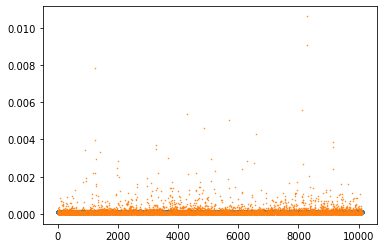

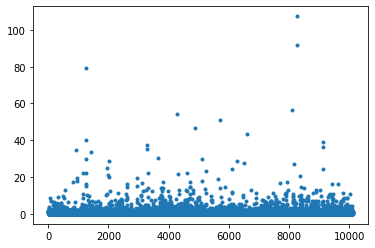

In [22]:
plt.plot(data[s].weights, '.')
plt.plot(Result.weights_new[s], '.', markersize=1)

plt.figure()
ratio = Result.weights_new[s]/data[s].weights
plt.plot(ratio, '.')
# plt.yscale('log')

Kish = 1/np.sum(Result.weights_new[s]**2)

print(Kish)
# print(np.exp(-Result.D_KL_alpha[s]))

rel_kish = np.sum(Result.weights_new[s]**2/data[s].weights)
print(rel_kish)

In [23]:
angles = data[s].forward_qs['backbone1_gamma'][:, 2]

In [89]:
data[s].f.shape

(8360, 12)

6


<Figure size 720x576 with 0 Axes>

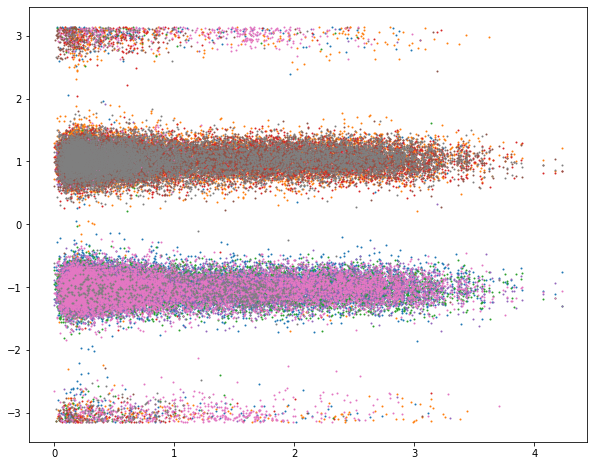

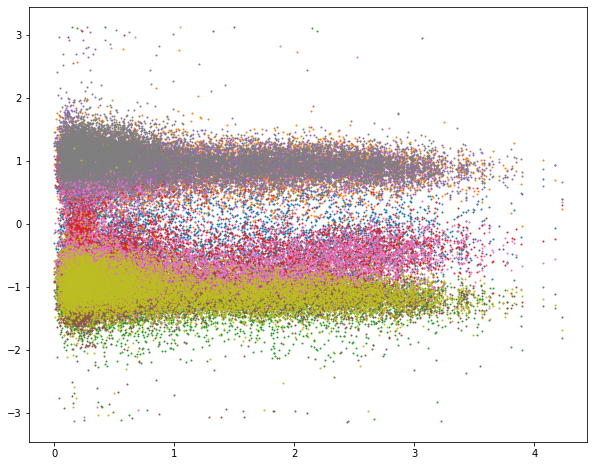

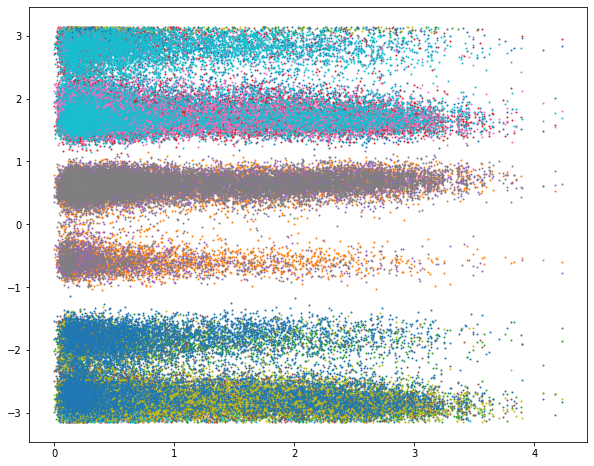

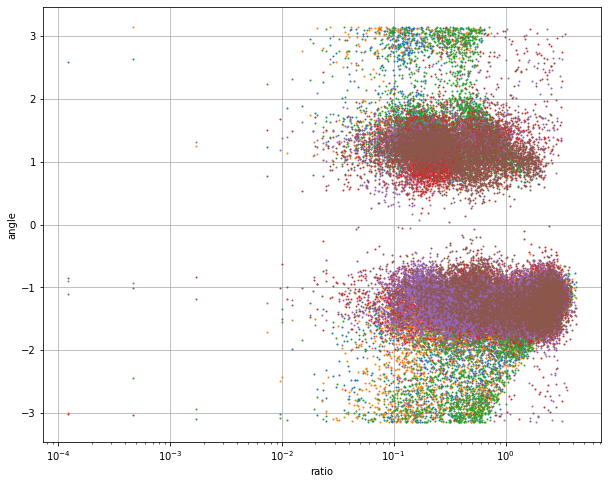

In [28]:
s = 'AAAA'

plt.figure(figsize=(10, 8))

ratio = Result.weights_new[s]/data[s].weights

for key in data[s].forward_qs.keys():
    plt.figure(figsize=(10, 8))
    length = len(data[s].forward_qs[key].T)
    for i in range(length):
        angles = data[s].forward_qs[key][:, i]
        # my_label = key + str(i)
        plt.plot(ratio, angles, '.', markersize=2)#, label=my_label)

plt.figure(figsize=(10, 8))
length = len(data[s].f.T)//2
print(length)
for i in range(length):

    angles = np.arcsin(data[s].f[:, i])
    wh = np.argwhere(data[s].f[:, i + length] < 0)
    angles[wh] = np.pi - angles[wh]
    angles = np.mod(angles, 2*np.pi)

    wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
    angles[wh] = angles[wh] - 2*np.pi

    plt.plot(ratio, angles, '.', markersize=2)

plt.xscale('log')
plt.xlabel('ratio')
plt.ylabel('angle')
# plt.legend()
plt.grid()
plt.show()

6


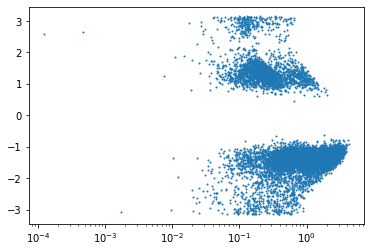

In [33]:
angles = data[s].f[:, 1]
ratio = Result.weights_new[s]/data[s].weights


length = len(data[s].f.T)//2
print(length)

i = 0

angles = np.arcsin(data[s].f[:, i])
wh = np.argwhere(data[s].f[:, i + length] < 0)
angles[wh] = np.pi - angles[wh]
angles = np.mod(angles, 2*np.pi)

wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
angles[wh] = angles[wh] - 2*np.pi

plt.plot(ratio, angles, '.', markersize=2)
plt.xscale('log')

In [ ]:
plt.hist(angles, weights=data[s].weights, bins=50, alpha=0.5, label='original')[1]
plt.hist(angles, weights=Result.weights_P[s], bins=50, alpha=0.5, label='reweighted')[1]
plt.grid()
plt.legend()

In [124]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [147]:
Result.reg_ff

{'AAAA': DeviceArray(0.35721436, dtype=float64),
 'CAAU': DeviceArray(0.36532376, dtype=float64),
 'CCCC': DeviceArray(0.3314244, dtype=float64),
 'GACC': DeviceArray(0.28684363, dtype=float64),
 'UUUU': DeviceArray(0.28652552, dtype=float64),
 'UCAAUC': DeviceArray(2.3386978, dtype=float64)}

so, the ensemble changes very little: what matters mostly is the forward model!

##### forward model

In [20]:
fm_coeffs_0

0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64

In [23]:
fm_coeffs['original']

0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64

In [ ]:
fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {}
fm_coeffs['original'] = fm_coeffs_0
fm_coeffs['Thorben'] = fm_coeffs_Thorben
fm_coeffs['mine'] = my_fm_coeffs

print(fm_coeffs)

In [18]:
my_fm_coeffs = pandas.Series({'A_gamma': 9.93293172, 'B_gamma': -1.75313237, 'C_gamma': -0.12452308,
'A_beta': 18.11038972, 'B_beta': -5.30036147, 'C_beta': 0.08335626,
'A_sugar': 6.98232334, 'B_sugar': -1.63483294, 'C_sugar': 0.66851206})

In [19]:
fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {}
fm_coeffs['original'] = fm_coeffs_0
fm_coeffs['Thorben'] = fm_coeffs_Thorben
fm_coeffs['mine'] = my_fm_coeffs

print(fm_coeffs)

{'original': 0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64, 'Thorben': 0
A_gamma    10.07
B_gamma    -1.87
C_gamma    -0.13
A_beta     18.34
B_beta     -5.39
C_beta      0.11
A_sugar     7.81
B_sugar    -2.05
C_sugar     0.25
Name: 1, dtype: float64, 'mine': A_gamma     9.932932
B_gamma    -1.753132
C_gamma    -0.124523
A_beta     18.110390
B_beta     -5.300361
C_beta      0.083356
A_sugar     6.982323
B_sugar    -1.634833
C_sugar     0.668512
dtype: float64}


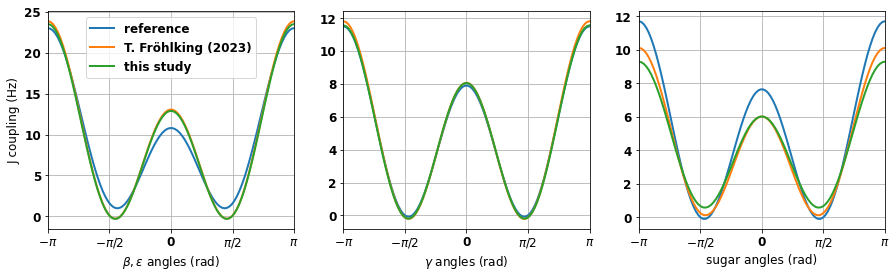

In [24]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

# plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)
titles = [r'$\beta,\epsilon$', r'$\gamma$', 'sugar']

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='reference')

    deltaV = compute_deltaV(fm_coeffs['Thorben'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='T. Fröhlking (2023)')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='this study') #   (average)')

    # deltaV = compute_deltaV(fm_coeffs['100 optimal'], angles, s) #  ['mean'], angles, s)
    # axs[i].plot(angles, deltaV, '-', label='this study 2') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel(titles[i] + ' angles (rad)')
    # axs[i].set_title(titles[i])
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_overall.png')
plt.show()